# Viscous traffic flow model

MFG system :
$$
\left\{\begin{array}{ll}
(\text { CE }) & \rho_{t}+(\rho u)_{x}=0 \\
(\text { HJB }) & V_{t}+f^{*}\left(V_{x}, \rho\right)=0 \\
& u=f_{p}^{*}\left(V_{x}, \rho\right)
\end{array}\right.
$$

- Legendre transformation : $-f^{*}(-p, \rho)$ with $f^{*}(p, \rho)=\min _{0 \leq \alpha \leq u_{\max }}\{f(\alpha, \rho)+\alpha p\}, \forall p \in \mathbb{R}$
- MFG-LWR : $f_{\mathrm{LWR}}(u, \rho)=\frac{1}{2}(U(\rho)-u)^{2} \Rightarrow f^{*}(p, \rho)=U(\rho)p-\frac{p^{2}}{2}$ and $f^{*}_{p}(p, \rho)=U(\rho)-p$

$$\left\{\begin{matrix}
\rho_{j}^{n+1}-\frac{1}{2}\left(\rho_{j-1}^{n}+\rho_{j+1}^{n}\right)+\frac{\Delta t}{2 \Delta x}\left(\rho_{j+1}^{n} u_{j+1}^{n}-\rho_{j-1}^{n} u_{j-1}^{n}\right)-\frac{\nu \Delta t}{\Delta x^{2}}\left ( \rho_{j+1}^{n}-2\rho_{j}^{n}+\rho_{j-1}^{n} \right )=0\\ 
V_{j}^{n+1}-V_{j}^{n}+\Delta t f^{*}\left(\frac{V_{j}^{n+1}-V_{j-1}^{n+1}}{\Delta x}, \rho_{j}^{n}\right)+ \frac{\nu \Delta t}{\Delta x^{2}}\left ( V_{j+1}^{n+1}-2V_{j}^{n+1}+V_{j-1}^{n+1} \right )=0\\ 
u_{j}^{n}-f_{p}^{*}\left(\frac{V_{j}^{n+1}-V_{j-1}^{n+1}}{\Delta x}, \rho_{j}^{n}\right)=0\\ 
\rho_{j}^{0}-\frac{1}{\Delta x} \int_{x_{j-1}}^{x_{j}} \rho_{0}(x) d x =0\\
\quad V_{j}^{N_{t}}-V_{T}\left(x_{j}\right) =0
\end{matrix}\right.$$

In [1]:
import numpy as np
from scipy import integrate
# pip install numdifftools
import numdifftools as nd
from scipy.optimize.nonlin import newton_krylov
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

In [19]:
def U(rho): # Greenshields desired speed
    return u_max*(1-rho/rho_jam)
def f_star(p,r): # p=Vx
#     return (p**3)/3+U(r)*p
#     return 0.5*(p**2)+U(r)*p # convexe
#     return 0.5*((p+1)**2) # convexe
    return -0.5*(p**2)+U(r)*p # MFG-LWR # concave
#     return r/rho_jam-0.5*(1-p*u_max)**2 # MFG-Separable # concave
def f_star_p(p,r):
#     return p**2+U(r)
#     return max(min(U(r)+p,u_max),0) # convexe
#     return max(min(p+1,u_max),0) # convexe
    return max(min(U(r)-p,u_max),0) # MFG-LWR # 0<=u<=u_max
#     return max(min(u_max*(1-p*u_max),u_max),0) # MFG-Separable
def integral(a,b): 
    x2 = lambda x: rho_int(x)
    I=integrate.quad(x2, a, b)
    return I[0]
def rho_int(s): # initial density
    return max(min(rho_a+(rho_b-rho_a)*np.exp(-0.5*((s-0.5*L)/gama)**2),rho_jam),0) # 0<=rho<=rho_jam
def VT(a): # Terminal cost
    return 0

def F(w):
    # FF=[F_rho,F_u,F_V,F_rho_int,F_V_ter], F_rho:0->Nt*Nx-1, F_u:Nt*Nx->2*Nt*Nx-1, F_V:2*Nt*Nx->3*Nt*Nx-1, F_rho_int:3*Nt*Nx->3*Nt*Nx+Nx-1, F_V_ter:3*Nt*Nx+Nx->3*Nt*Nx+2*Nx-1
    FF=np.zeros(3*Nt*Nx+2*Nx)
    for n in range(0,Nt):
        # F_rho , F[0]->F[Nt-1] ************** 1
        FF[n]=w[n+1]-0.5*w[n+Nt+1]+(0.5*dt/dx)*w[n+Nt+1]*w[n+(Nt+1)*Nx+Nt]+ep1*(w[n+Nt+1]-2*w[n])
        # F_rho , F[Nt*Nx-Nt]->F[Nt*Nx-1] ********** 3
        FF[Nt*(Nx-1)+n]=w[(Nt+1)*(Nx-1)+n+1]-0.5*w[(Nt+1)*(Nx-2)+n]-(0.5*dt/dx)*w[(Nt+1)*(Nx-2)+n]*w[(Nt+1)*Nx+(Nx-2)*Nt+n]+ep1*(-2*w[(Nt+1)*(Nx-1)+n]+w[(Nt+1)*(Nx-2)+n])
        # F_u , F[Nt*Nx]->F[Nt*Nx+Nt-1] *********** 4
        FF[Nt*Nx+n]=w[(Nt+1)*Nx+n]-f_star_p(w[(2*Nt+1)*Nx+n+1]/dx,w[n])
        # F_u , F[2*Nt*Nx-Nt]->F[2*Nt*Nx-1] ********* 6
        FF[2*Nt*Nx-Nt+n]=w[2*Nt*Nx+Nx-Nt+n]-f_star_p((w[3*Nt*Nx+2*Nx-Nt+n]-w[3*Nt*Nx+2*Nx-2*Nt+n-1])/dx,w[Nt*Nx+Nx-Nt+n-1])
        # F_V , F[2*Nt*Nx]->F[2*Nt*Nx+Nt-1] *********** 7
        FF[2*Nt*Nx+n]=w[(2*Nt+1)*Nx+n+1]-w[(2*Nt+1)*Nx+n]+dt*f_star(w[(2*Nt+1)*Nx+n+1]/dx,w[n])+ep2*(w[(2*Nt+1)*Nx+Nt+n+2]-2*w[(2*Nt+1)*Nx+n+1])
        # F_V , F[3*Nt*Nx-Nt]->F[3*Nt*Nx-1] ********** 9
        FF[3*Nt*Nx-Nt+n]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n]+dt*f_star((w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])/dx,w[(Nx-1)*(Nt+1)+n])+ep2*(-2*w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])
    for j in range(2,Nx):
        for n in range(0,Nt):
            # F_rho , F[Nt]->F[Nt*Nx-Nt-1] ************ 2
            FF[(j-1)*Nt+n]=w[(j-1)*(Nt+1)+n+1]-0.5*(w[(j-2)*(Nt+1)+n]+w[j*(Nt+1)+n])+(0.5*dt/dx)*(w[j*(Nt+1)+n]*w[(Nt+1)*Nx+j*Nt+n]-w[(j-2)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-2)*Nt+n])+ep1*(w[j*(Nt+1)+n]-2*w[(j-1)*(Nt+1)+n]+w[(j-2)*(Nt+1)+n])
            # F_u , F[Nt*Nx+Nt]->F[2*Nt*Nx-Nt-1] *********** 5
            FF[(j-1)*Nt+Nt*Nx+n]=w[(Nt+1)*Nx+(j-1)*Nt+n]-f_star_p((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])
            # F_V , F[2*Nt*Nx+Nt]->F[3*Nt*Nx-Nt-1] ********* 8
            FF[(j-1)*Nt+2*Nt*Nx+n]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]+dt*f_star((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])+ep2*(w[(2*Nt+1)*Nx+j*(Nt+1)+n+1]-2*w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])
        # F_rho_int , F[3*Nt*Nx+1]->F[3*Nt*Nx+Nx-2] ********** 11
        FF[3*Nt*Nx+j-1]=w[(j-1)*(Nt+1)]-(1/dt)*integral(x[j-1],x[j])
        # F_V_ter , F[3*Nt*Nx+Nx+1]->F[3*Nt*Nx+2*Nx-2] ********* 14
        FF[3*Nt*Nx+Nx+j-1]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]-VT(x[j])
    # F_rho_int , F[3*Nt*Nx] ********* 10
    FF[3*Nt*Nx]=w[0]-(1/dt)*integral(x[0],x[1])
    # F_rho_int , F[3*Nt*Nx+Nx-1] ********* 12
    FF[3*Nt*Nx+Nx-1]=w[(Nx-1)*(Nt+1)]-(1/dt)*integral(x[Nx-1],x[Nx])
    # F_V_ter , F[3*Nt*Nx+Nx] *********** 13 
    FF[3*Nt*Nx+Nx]=w[(2*Nt+1)*Nx+Nt]-VT(x[1])
    # F_V_ter , F[3*Nt*Nx+2*Nx-1] ************** 15
    FF[3*Nt*Nx+2*Nx-1]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+Nt]-VT(x[Nx])
    
    return FF

def Fapp(w): # Ignoring the forward-backward coupling  parts
    # FF=[F_rho,F_u,F_V,F_rho_int,F_V_ter], F_rho:0->Nt*Nx-1, F_u:Nt*Nx->2*Nt*Nx-1, F_V:2*Nt*Nx->3*Nt*Nx-1, F_rho_int:3*Nt*Nx->3*Nt*Nx+Nx-1, F_V_ter:3*Nt*Nx+Nx->3*Nt*Nx+2*Nx-1
    FF=np.zeros(3*Nt*Nx+2*Nx)
    for n in range(0,Nt):
        # F_rho , F[0]->F[Nt-1] ************** 1
        FF[n]=w[n+1]-0.5*w[n+Nt+1]+(0.5*dt/dx)*w[n+Nt+1]*w[n+(Nt+1)*Nx+Nt]+ep1*(w[n+Nt+1]-2*w[n])
        # F_rho , F[Nt*Nx-Nt]->F[Nt*Nx-1] ********** 3
        FF[Nt*(Nx-1)+n]=w[(Nt+1)*(Nx-1)+n+1]-0.5*w[(Nt+1)*(Nx-2)+n]-(0.5*dt/dx)*w[(Nt+1)*(Nx-2)+n]*w[(Nt+1)*Nx+(Nx-2)*Nt+n]+ep1*(-2*w[(Nt+1)*(Nx-1)+n]+w[(Nt+1)*(Nx-2)+n])
        # F_u , F[Nt*Nx]->F[Nt*Nx+Nt-1] *********** 4
        FF[Nt*Nx+n]=w[(Nt+1)*Nx+n]
        # F_u , F[2*Nt*Nx-Nt]->F[2*Nt*Nx-1] ********* 6
        FF[2*Nt*Nx-Nt+n]=w[2*Nt*Nx+Nx-Nt+n]
        # F_V , F[2*Nt*Nx]->F[2*Nt*Nx+Nt-1] *********** 7
        FF[2*Nt*Nx+n]=w[(2*Nt+1)*Nx+n+1]-w[(2*Nt+1)*Nx+n]+ep2*(w[(2*Nt+1)*Nx+Nt+n+2]-2*w[(2*Nt+1)*Nx+n+1])
        # F_V , F[3*Nt*Nx-Nt]->F[3*Nt*Nx-1] ********** 9
        FF[3*Nt*Nx-Nt+n]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n]+ep2*(-2*w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])
    for j in range(2,Nx):
        for n in range(0,Nt):
            # F_rho , F[Nt]->F[Nt*Nx-Nt-1] ************ 2
            FF[(j-1)*Nt+n]=w[(j-1)*(Nt+1)+n+1]-0.5*(w[(j-2)*(Nt+1)+n]+w[j*(Nt+1)+n])+(0.5*dt/dx)*(w[j*(Nt+1)+n]*w[(Nt+1)*Nx+j*Nt+n]-w[(j-2)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-2)*Nt+n])+ep1*(w[j*(Nt+1)+n]-2*w[(j-1)*(Nt+1)+n]+w[(j-2)*(Nt+1)+n])
            # F_u , F[Nt*Nx+Nt]->F[2*Nt*Nx-Nt-1] *********** 5
            FF[(j-1)*Nt+Nt*Nx+n]=w[(Nt+1)*Nx+(j-1)*Nt+n]
            # F_V , F[2*Nt*Nx+Nt]->F[3*Nt*Nx-Nt-1] ********* 8
            FF[(j-1)*Nt+2*Nt*Nx+n]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]+ep2*(w[(2*Nt+1)*Nx+j*(Nt+1)+n+1]-2*w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])
        # F_rho_int , F[3*Nt*Nx+1]->F[3*Nt*Nx+Nx-2] ********** 11
        FF[3*Nt*Nx+j-1]=w[(j-1)*(Nt+1)]-(1/dt)*integral(x[j-1],x[j])
        # F_V_ter , F[3*Nt*Nx+Nx+1]->F[3*Nt*Nx+2*Nx-2] ********* 14
        FF[3*Nt*Nx+Nx+j-1]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]-VT(x[j])
    # F_rho_int , F[3*Nt*Nx] ********* 10
    FF[3*Nt*Nx]=w[0]-(1/dt)*integral(x[0],x[1])
    # F_rho_int , F[3*Nt*Nx+Nx-1] ********* 12
    FF[3*Nt*Nx+Nx-1]=w[(Nx-1)*(Nt+1)]-(1/dt)*integral(x[Nx-1],x[Nx])
    # F_V_ter , F[3*Nt*Nx+Nx] *********** 13 
    FF[3*Nt*Nx+Nx]=w[(2*Nt+1)*Nx+Nt]-VT(x[1])
    # F_V_ter , F[3*Nt*Nx+2*Nx-1] ************** 15
    FF[3*Nt*Nx+2*Nx-1]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+Nt]-VT(x[Nx])
    
    return FF

xglo = None
def get_preconditioner(a):
    Jac=nd.Jacobian(Fapp)
    J1=Jac(a)
    # the *incomplete LU* decomposition
    J1_ilu = spla.spilu(J1)
    # matrix-vector product -> LinearOperator 
    M_x = lambda r: J1_ilu.solve(r)
    M = spla.LinearOperator(J1.shape, M_x)

    def xglobal( x, Fapp ):
            """ newton_krylov calls this at each iteration: xglo = x """
            global xglo
            xglo = x.copy()
    M.update = xglobal

    return M

In [ ]:
# %%prun -s cumulative -q -l 10 -T prun0
# We profile the cell, sort the report by "cumulative
# time", limit it to 10 lines, and save it to a file
# named "prun0".

T=3 # horizon length 
N=1 # number of cars 
Nx=40; Nt=20 # spatial-temporal grid sizes
u_max=1 # free flow speed
rho_jam=1 # jam density
L=N # road length
CFL=0.75    # CFL<1
EPS=0.45   # EPS<0.5
rho_a=0.05; rho_b=0.95; gama=0.1
dx=round(L/Nx,3) # spatial step size
print('dx=',dx)
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)

""" Non-viscous solution""" 
dt=round(min(T/Nt,CFL*dx/abs(u_max)),3) # temporal step size
print('dt_nvisc=',dt)
ep1=0  # rho
ep2=0  # V
# solve
guess = np.zeros(3*Nt*Nx+2*Nx)
t0 = time.process_time()   ###
sol0 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# print(sol0)

""" Viscous solution"""
mu=0.01 # viscosity coefficient 
dt=round(min(T/Nt,CFL*dx/abs(u_max),EPS*(dx**2)/mu),3) # temporal step size
dt=dt/10
print('dt_visc=',dt)
ep1=-mu*dt/(dx**2)  # rho
ep2=mu*dt/(dx**2) # V
# solve
guess = sol0
t0 = time.process_time()   ###
sol1 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# # # print(sol1)
# print(open('prun0', 'r').read())

dx= 0.025
dt_nvisc= 0.019


In [21]:
rho=np.zeros((Nx+1,Nt+1))
u=np.zeros((Nx+1,Nt))
V=np.zeros((Nx+1,Nt+1))
Q=np.zeros((Nx+1,Nt))
for j in range(1,Nx+1):
    for n in range(0,Nt):
        rho[j,n]=sol1[(j-1)*(Nt+1)+n]
        u[j,n]=sol1[(Nt+1)*Nx+(j-1)*Nt+n]
        V[j,n]=sol1[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
        Q[j,n]=rho[j,n]*u[j,n]
    rho[j,Nt]=sol1[(j-1)*(Nt+1)+Nt]
    V[j,Nt]=sol1[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
for n in range(0,Nt+1): # periodic boundary conditions
    rho[0,n]=rho[Nx,n]
    V[0,n]=V[Nx,n]
for n in range(0,Nt):
    u[0,n]=f_star_p(V[1,n]/dx,rho[0,n])
    Q[0,n]=rho[0,n]*u[0,n]
# print("rho=",rho)
# print("u=",u)
# print("V=",V)

Text(0.5, 1.0, 'Fundamental diagram (mu=0.01, T=3)')

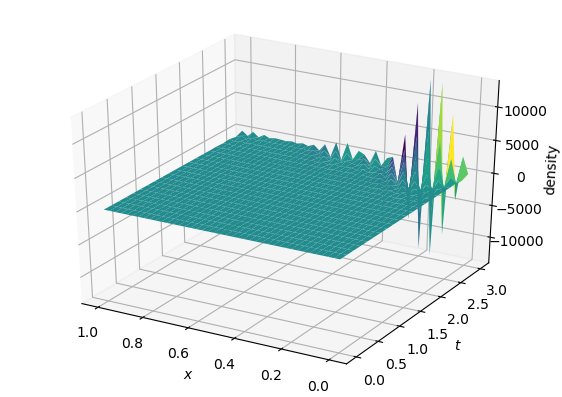

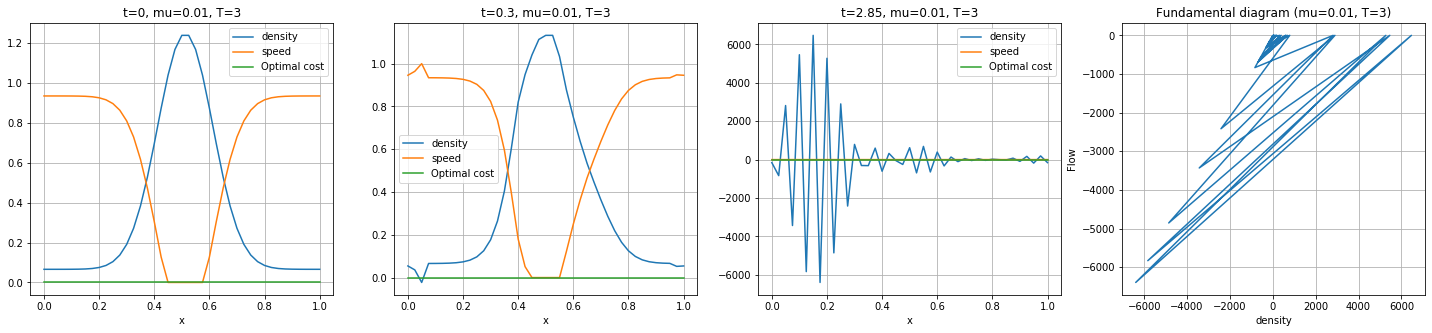

In [22]:
# visualize
tt, xx = np.meshgrid(t, x)
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('density')
ax.invert_xaxis()

plt.figure(figsize=(25, 5))
plt.subplot(1,4,1)
plt.plot(x,rho[:,0],label='density')
plt.plot(x,u[:,0],label='speed')
plt.plot(x,V[:,0],label='Optimal cost')
plt.legend()
plt.grid()
plt.title("t=0, mu={mu}, T={T}".format(mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,2)
plt.plot(x,rho[:,2],label='density')
plt.plot(x,u[:,2],label='speed')
plt.plot(x,V[:,2],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[2],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,3)
plt.plot(x,rho[:,Nt-1],label='density')
plt.plot(x,u[:,Nt-1],label='speed')
plt.plot(x,V[:,Nt-1],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[Nt-1],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,4)
plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
plt.xlabel('density')
plt.ylabel('Flow')
plt.grid()
plt.title("Fundamental diagram (mu={mu}, T={T})".format(mu=mu,T=T))

In [23]:
# %%prun -s cumulative -q -l 10 -T prun0
# We profile the cell, sort the report by "cumulative
# time", limit it to 10 lines, and save it to a file
# named "prun0".

T=0.5 # horizon length 
N=1 # number of cars 
Nx=40; Nt=10 # spatial-temporal grid sizes
u_max=1 # free flow speed
rho_jam=1 # jam density
L=N # road length
CFL=0.75    # CFL<1
EPS=0.45   # EPS<0.5
rho_a=0.05; rho_b=0.95; gama=0.1
dx=round(L/Nx,3) # spatial step size
print('dx=',dx)
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)

""" Non-viscous solution""" 
dt=round(min(T/Nt,CFL*dx/abs(u_max)),3) # temporal step size
print('dt_nvisc=',dt)
ep1=0  # rho
ep2=0  # V
# solve
guess = np.zeros(3*Nt*Nx+2*Nx)
t0 = time.process_time()   ###
sol0 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# print(sol0)

""" Viscous solution"""
mu=0.01 # viscosity coefficient 
dt=round(min(T/Nt,CFL*dx/abs(u_max),EPS*(dx**2)/mu),3) # temporal step size
print('dt_visc=',dt)
ep1=-mu*dt/(dx**2)  # rho
ep2=mu*dt/(dx**2) # V
# solve
guess = sol0
t0 = time.process_time()   ###
sol2 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# # # print(sol2)
# print(open('prun0', 'r').read())

dx= 0.025
dt_nvisc= 0.019
0:  |F(x)| = 1; step 1
1:  |F(x)| = 0.397151; step 1
2:  |F(x)| = 0.209231; step 1


C:\Users\amach\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


3:  |F(x)| = 0.0386471; step 1
4:  |F(x)| = 0.0113496; step 1
5:  |F(x)| = 3.83269e-07; step 1
Time spent 525.515625
dt_visc= 0.019
0:  |F(x)| = 0.041879; step 0.000177495
1:  |F(x)| = 0.0418716; step 0.000178102
2:  |F(x)| = 0.0418637; step 0.00019325


C:\Users\amach\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


3:  |F(x)| = 0.0418558; step 0.000193179
4:  |F(x)| = 0.0418479; step 0.000194749
5:  |F(x)| = 0.04184; step 0.000194765
6:  |F(x)| = 0.0418321; step 0.000194701
7:  |F(x)| = 0.0418242; step 0.00019464
8:  |F(x)| = 0.0418163; step 0.000194582
9:  |F(x)| = 0.0418076; step 0.000225021
10:  |F(x)| = 0.0417989; step 0.000224957
11:  |F(x)| = 0.0417902; step 0.000224904
12:  |F(x)| = 0.0417815; step 0.000224861
13:  |F(x)| = 0.0417726; step 0.000232537
14:  |F(x)| = 0.0417638; step 0.000232515
15:  |F(x)| = 4.15741; step 1
16:  |F(x)| = 2.68944; step 1
17:  |F(x)| = 2.76668; step 1
18:  |F(x)| = 2.75274; step 1
19:  |F(x)| = 2.75516; step 1
20:  |F(x)| = 2.75473; step 1
21:  |F(x)| = 2.74681; step 1
22:  |F(x)| = 2.62041; step 1
23:  |F(x)| = 2.78455; step 1
24:  |F(x)| = 2.75383; step 1
25:  |F(x)| = 2.75889; step 1
26:  |F(x)| = 2.75163; step 1
27:  |F(x)| = 2.75942; step 1
28:  |F(x)| = 2.74583; step 1
29:  |F(x)| = 2.77974; step 0.172684
30:  |F(x)| = 3.08477; step 1
31:  |F(x)| = 3.029

In [24]:
rho=np.zeros((Nx+1,Nt+1))
u=np.zeros((Nx+1,Nt))
V=np.zeros((Nx+1,Nt+1))
Q=np.zeros((Nx+1,Nt))
for j in range(1,Nx+1):
    for n in range(0,Nt):
        rho[j,n]=sol2[(j-1)*(Nt+1)+n]
        u[j,n]=sol2[(Nt+1)*Nx+(j-1)*Nt+n]
        V[j,n]=sol2[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
        Q[j,n]=rho[j,n]*u[j,n]
    rho[j,Nt]=sol2[(j-1)*(Nt+1)+Nt]
    V[j,Nt]=sol2[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
for n in range(0,Nt+1): # periodic boundary conditions
    rho[0,n]=rho[Nx,n]
    V[0,n]=V[Nx,n]
for n in range(0,Nt):
    u[0,n]=f_star_p(V[1,n]/dx,rho[0,n])
    Q[0,n]=rho[0,n]*u[0,n]
# print("rho=",rho)
# print("u=",u)
# print("V=",V)

Text(0.5, 1.0, 'Fundamental diagram (mu=0.01, T=0.5)')

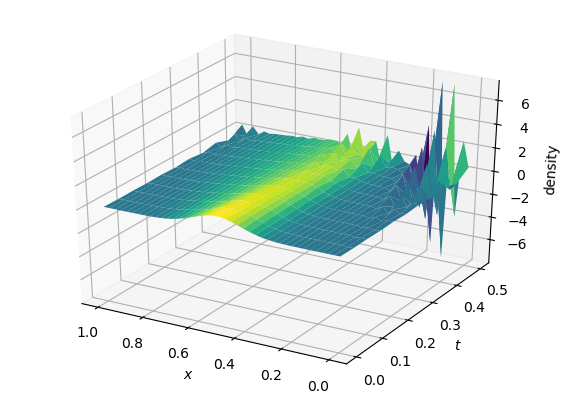

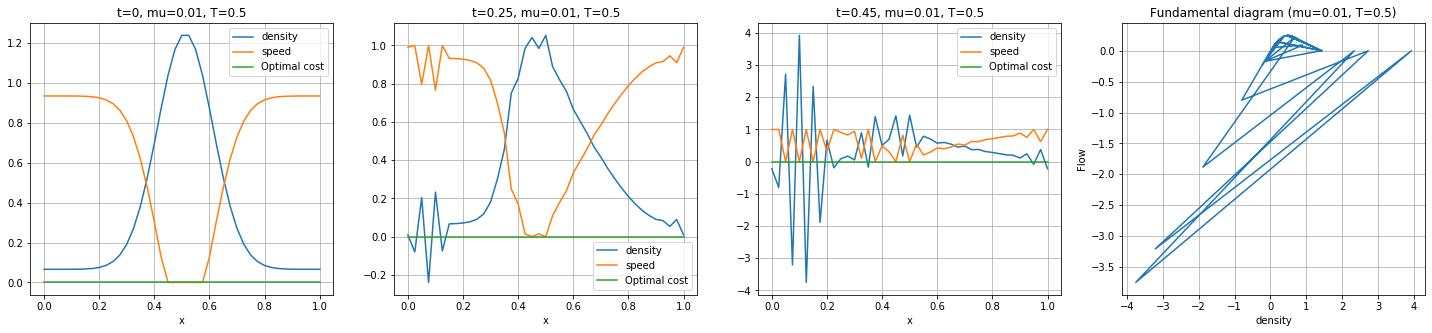

In [25]:
# visualize
tt, xx = np.meshgrid(t, x)
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('density')
ax.invert_xaxis()

plt.figure(figsize=(25, 5))
plt.subplot(1,4,1)
plt.plot(x,rho[:,0],label='density')
plt.plot(x,u[:,0],label='speed')
plt.plot(x,V[:,0],label='Optimal cost')
plt.legend()
plt.grid()
plt.title("t=0, mu={mu}, T={T}".format(mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,2)
plt.plot(x,rho[:,5],label='density')
plt.plot(x,u[:,5],label='speed')
plt.plot(x,V[:,5],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[5],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,3)
plt.plot(x,rho[:,Nt-1],label='density')
plt.plot(x,u[:,Nt-1],label='speed')
plt.plot(x,V[:,Nt-1],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[Nt-1],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,4)
plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
plt.xlabel('density')
plt.ylabel('Flow')
plt.grid()
plt.title("Fundamental diagram (mu={mu}, T={T})".format(mu=mu,T=T))

In [29]:
# %%prun -s cumulative -q -l 10 -T prun0
# We profile the cell, sort the report by "cumulative
# time", limit it to 10 lines, and save it to a file
# named "prun0".

T=3 # horizon length 
N=1 # number of cars 
Nx=20; Nt=40 # spatial-temporal grid sizes
u_max=1 # free flow speed
rho_jam=1 # jam density
L=N # road length
CFL=0.75    # CFL<1
EPS=0.45   # EPS<0.5
rho_a=0.05; rho_b=0.95; gama=0.1
dx=round(L/Nx,3) # spatial step size
print('dx=',dx)
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)

""" Non-viscous solution""" 
dt=round(min(T/Nt,CFL*dx/abs(u_max)),3) # temporal step size
print('dt_nvisc=',dt)
ep1=0  # rho
ep2=0  # V
# solve
guess = np.zeros(3*Nt*Nx+2*Nx)
t0 = time.process_time()   ###
sol0 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# print(sol0)

""" Viscous solution"""
mu=0.01 # viscosity coefficient 
dt=round(min(T/Nt,CFL*dx/abs(u_max),EPS*(dx**2)/mu),3) # temporal step size
print('dt_visc=',dt)
ep1=mu*dt/(dx**2)  # rho
ep2=-mu*dt/(dx**2) # V
# solve
guess = sol0
t0 = time.process_time()   ###
sol3 = newton_krylov(F, guess, method='lgmres', verbose=1, inner_M=get_preconditioner(guess))
t1 = time.process_time()   ###
print("Time spent", t1 - t0)
# # # print(sol3)
# print(open('prun0', 'r').read())

dx= 0.05
dt_nvisc= 0.038
0:  |F(x)| = 1; step 1
1:  |F(x)| = 0.23148; step 1


C:\Users\amach\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


2:  |F(x)| = 0.0443589; step 1
3:  |F(x)| = 0.0157467; step 1
4:  |F(x)| = 0.000485494; step 1
5:  |F(x)| = 9.62415e-06; step 1
6:  |F(x)| = 1.46549e-13; step 1
Time spent 1661.546875
dt_visc= 0.038


C:\Users\amach\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


0:  |F(x)| = 0.0251832; step 1
1:  |F(x)| = 0.00767226; step 1
2:  |F(x)| = 4.17516e-06; step 1
Time spent 1707.8125


In [27]:
rho=np.zeros((Nx+1,Nt+1))
u=np.zeros((Nx+1,Nt))
V=np.zeros((Nx+1,Nt+1))
Q=np.zeros((Nx+1,Nt))
for j in range(1,Nx+1):
    for n in range(0,Nt):
        rho[j,n]=sol3[(j-1)*(Nt+1)+n]
        u[j,n]=sol3[(Nt+1)*Nx+(j-1)*Nt+n]
        V[j,n]=sol3[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
        Q[j,n]=rho[j,n]*u[j,n]
    rho[j,Nt]=sol3[(j-1)*(Nt+1)+Nt]
    V[j,Nt]=sol3[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
for n in range(0,Nt+1): # periodic boundary conditions
    rho[0,n]=rho[Nx,n]
    V[0,n]=V[Nx,n]
for n in range(0,Nt):
    u[0,n]=f_star_p(V[1,n]/dx,rho[0,n])
    Q[0,n]=rho[0,n]*u[0,n]
# print("rho=",rho)
# print("u=",u)
# print("V=",V)

Text(0.5, 1.0, 'Fundamental diagram (mu=0.01, T=3)')

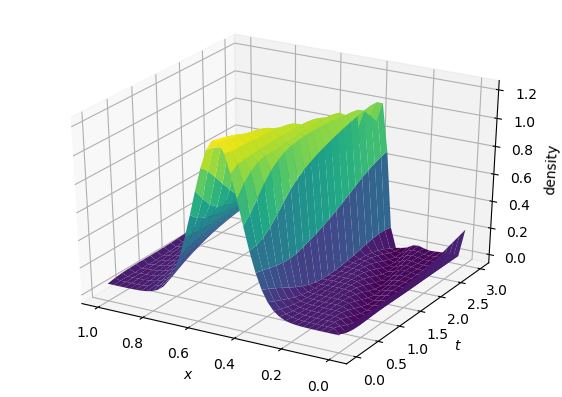

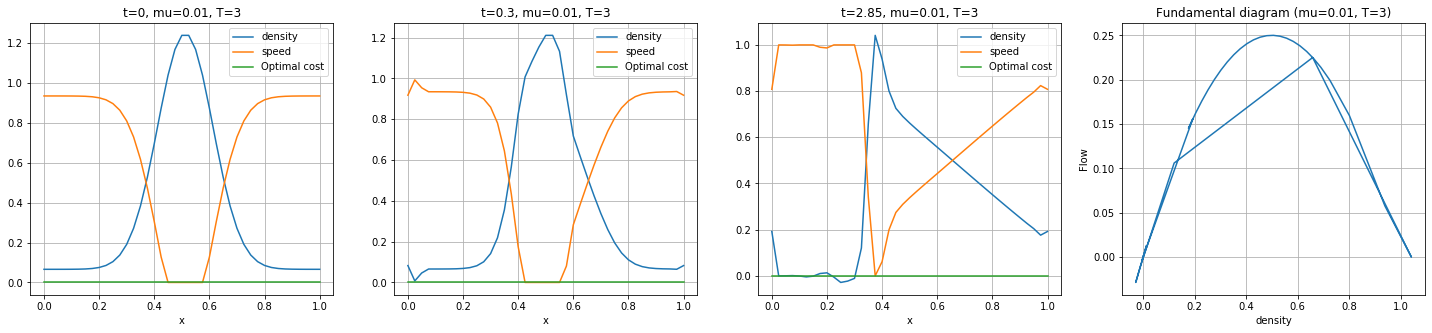

In [28]:
# visualize
tt, xx = np.meshgrid(t, x)
fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('density')
ax.invert_xaxis()

plt.figure(figsize=(25, 5))
plt.subplot(1,4,1)
plt.plot(x,rho[:,0],label='density')
plt.plot(x,u[:,0],label='speed')
plt.plot(x,V[:,0],label='Optimal cost')
plt.legend()
plt.grid()
plt.title("t=0, mu={mu}, T={T}".format(mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,2)
plt.plot(x,rho[:,2],label='density')
plt.plot(x,u[:,2],label='speed')
plt.plot(x,V[:,2],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[2],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,3)
plt.plot(x,rho[:,Nt-1],label='density')
plt.plot(x,u[:,Nt-1],label='speed')
plt.plot(x,V[:,Nt-1],label='Optimal cost')
plt.grid()
plt.legend()
plt.title("t={t}, mu={mu}, T={T}".format(t=round(t[Nt-1],3),mu=mu,T=T))
plt.xlabel('x')
plt.subplot(1,4,4)
plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
plt.xlabel('density')
plt.ylabel('Flow')
plt.grid()
plt.title("Fundamental diagram (mu={mu}, T={T})".format(mu=mu,T=T))